In [2]:
import os
import itertools
import random

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.colors import LinearSegmentedColormap
from cycler import cycler

import numpy as np
from scipy.stats import *
import pandas as pd
import seaborn as sns
import pyro as pyro

from arspy import ars
from math import gamma

In [4]:
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino'], 'size':14})
rc('text', usetex=True)
plt.rc('axes', prop_cycle=(cycler('color', ['red', 'gray', 'black'])))#, 'blue', 'green'])))

# Adaptive Rejection Sampling
code from https://random-walks.org/content/misc/ars/ars.html#

In [5]:
from ars import *

- Unnormalized distribution function $f$
- log function $h(x) = log f(x)$
- Envelope $g_u$. Minimum over the tangents to h at abscissa points
- Squeezing function $g_l$. Piecewise linear function which joins the points $(x_k, h(x_k))$
- Abscissa set $T_k = {x_1 < x_2 < ... < x_K}$


We are using now the prior distribution (Gaussian)

In [312]:
# The log unnormalised density to illustrate
log_prob = log_gaussian(0., 100.)

# Points in the abcissa set and corresponding log-probabilities and gradients
xs = np.array([-10., 0.1, 15])
hs, dhdxs = log_prob(xs)


We plot the normalized probability 

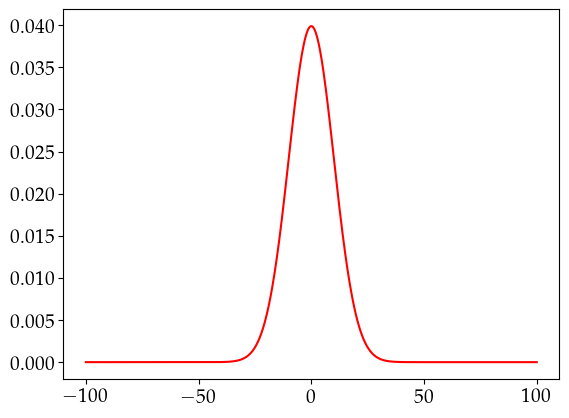

In [315]:
x = np.linspace(-100,100,1000)
plt.plot(x, np.exp(log_prob(x)[0])/ (2 * np.pi*100) ** 0.5)

''

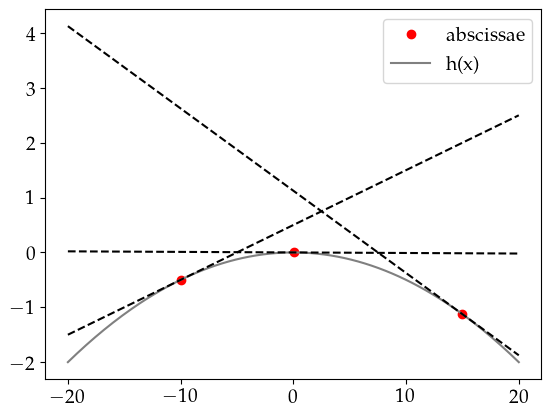

In [316]:
plt.plot(xs, hs, "o", label="abscissae")
x = np.linspace(-20,20,200)
plt.plot(x, log_prob(x)[0], label="h(x)")
for c in range(len(xs)):
    plt.plot(x, dhdxs[c]*(x-xs[c]) + hs[c], "k--")
#plt.xlim(*x_lim)
plt.legend()
;

Then we want the find the points where the tangent lines intersept z. For that we need the intercept points of the tangent lines which are given by y = h'x + c

In [317]:
z,c = compute_points_of_intersection_and_intercepts(xs, hs, dhdxs)

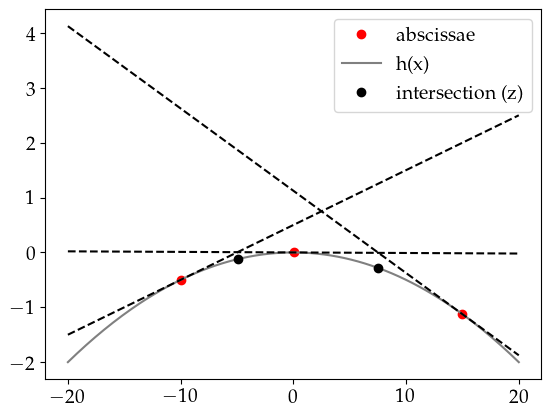

In [318]:
plt.plot(xs, hs, "o", label="abscissae")
x = np.linspace(-20,20,200)
plt.plot(x, log_prob(x)[0], label="h(x)")

for i in range(3):
    plt.plot(x, dhdxs[i]*x + c[i], "k--")

plt.plot(z, log_prob(z)[0], "o", label="intersection (z)")
#plt.ylim(-0.00013,-0.0001)
#plt.xlim(0.145,0.16)
plt.legend()

The black dots are going to devide our function into three sections. We will estimate the envelope function using the tangent lines of the most proximate red point (exponentiated)

In [319]:
# Locations to plot the log unnorm. density and envelope/squeezing functions
x_plot = np.linspace(-100, 100, 200)
log_probs = [log_prob(x)[0] for x in x_plot]
gu = [g_u(x, xs, hs, dhdxs) for x in x_plot]
gl = [g_l(x, xs, hs) for x in x_plot]


Text(0.5, 1.0, 'Squeezing function')

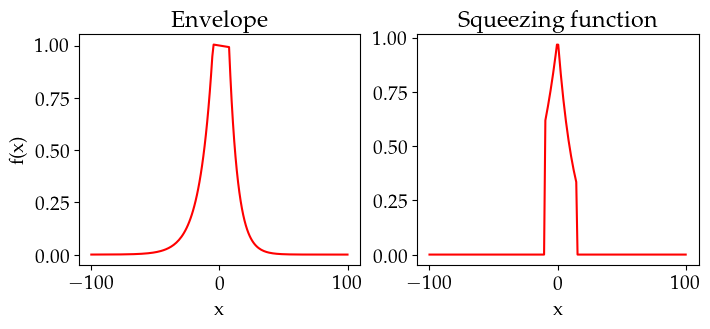

In [320]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(x_plot, gu)
plt.ylabel("f(x)")
plt.xlabel("x")
plt.title("Envelope")

plt.subplot(1,2,2)
plt.plot(x_plot, gl)
plt.xlabel("x")
#plt.ylim(np.min(gu), np.max(gu))
plt.title("Squeezing function")

We see here the envelope and squeezing function in linear scale (which means the functions are exponentiated).

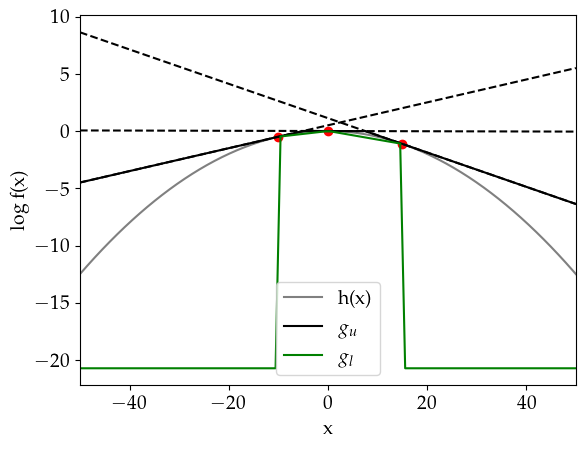

In [321]:
plt.plot(xs, hs, "o")
x = np.linspace(-50, 50, 200)
plt.plot(x, log_prob(x)[0], label="h(x)")

for i in range(3):
    plt.plot(x, dhdxs[i]*x + c[i], "k--")

plt.plot(x_plot, np.log(gu), label=r"$g_u$")
#floored_log_gl = np.zeros(len(gl))
#floored_log_gl[gl>0] = gl[gl>0]
floored_log_gl = np.log(np.maximum(np.array(gl), np.ones_like(gl) * 1e-9))
plt.plot(x_plot, floored_log_gl, "green",label=r"$g_l$")

plt.xlim(-50,50)
#plt.ylim(np.min(log_probs),np.log(np.max(gu))+0.01)
plt.xlabel("x")
plt.ylabel("log f(x)")
plt.legend()

If we sample a point at random from the area under $g_u$, and this point also happens to be in the area under f, then the point in uniformly distributed in the area under f, and is a exactly sample from the target distribution.

1. Initilize abscissa set $T_k$, such taht $f'(x_1) > 0 $ and $f'(x_k) < 0$. Also $g_u, g_l$.
2. Sample 
$$x' \sim \frac{g_u(x)}{\int g_u(x')dx'}\quad \text{and}\quad z \sim U(0,1)$$

squeezing and rejection tests. 
If
$$z \leq \frac{g_l(x')}{g_u(x')}$$
accept x'.

If else,
$$z \leq \frac{h(x')}{g_u(x')}$$

accept point. Else, reject it.

3. If x' was accepted at the squeezing test, go to step 2. Otherwise insert x' into the abscissa set and update $g_l$ and $g_u$ and return to step 2.

In [322]:
x_plot = np.linspace(-50, 50, 200)
lims, probs = envelope_limits_and_unnormalised_probabilities(xs, hs, dhdxs)


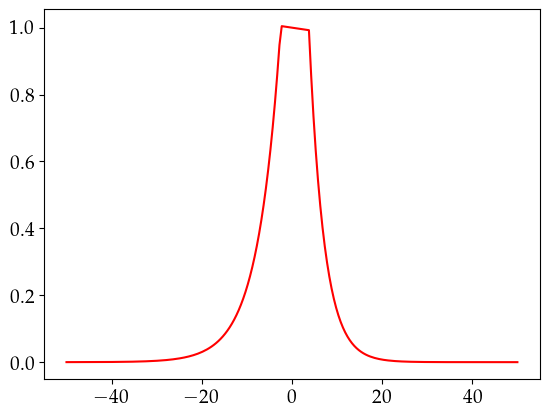

In [325]:
plt.plot(x_plot, gu)

In [323]:
lims

array([[ -inf, -4.95],
       [-4.95,  7.55],
       [ 7.55,   inf]])

In [237]:
samples = [sample_envelope(xs, hs, dhdxs, lims=(float("-inf"),float("inf"))) for i in range(1000)]
gu = [g_u(x, xs, hs, dhdxs) / np.sum(probs) for x in x_plot]


Text(0.5, 0, 'x')

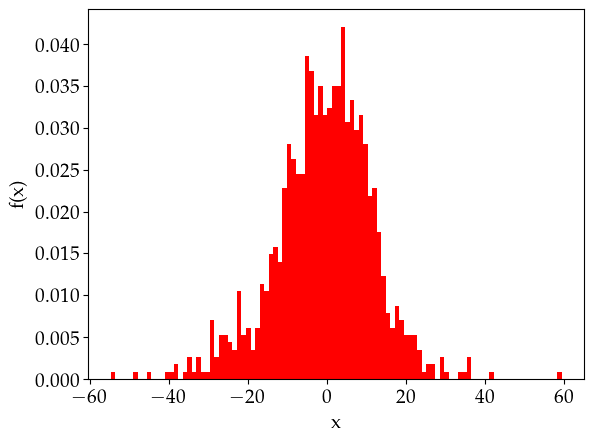

In [241]:
plt.hist(samples, density=True, bins=100)
plt.ylabel("f(x)")
plt.xlabel("x")


''

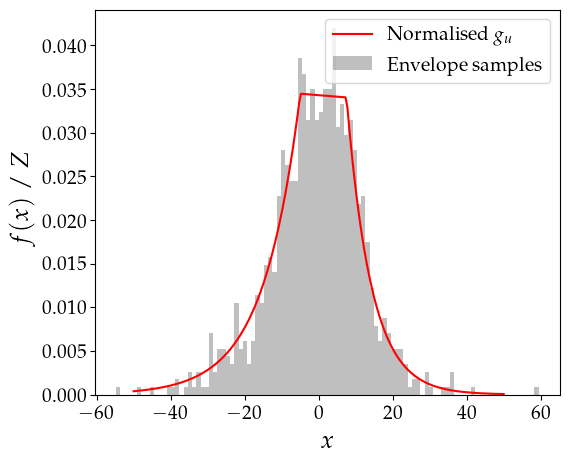

In [246]:
# Plot samples and envelope
plt.figure(figsize=(6, 5))
plt.plot(x_plot,
        gu,
        color='red',
        label='Normalised $g_u$')

plt.hist(samples,
        density=True,
        bins=100,
        color='gray',
        alpha=0.5,
        label='Envelope samples')
        
# Plot formatting
plt.title('', fontsize=20)
#plt.xlim([-4, 4])
#plt.ylim([0, 0.5])
plt.xlabel('$x$', fontsize=18)
plt.ylabel('$f(x)~/~Z$', fontsize=18)
plt.legend(loc='upper right')
;


First we define the probability we want to sample from

In [270]:
target_mean = 0.
target_variance = 100.

x0 = -20.
num_samples = 10000

log_unnorm_prob = log_gaussian(mean=target_mean, variance=target_variance)

Parameters of the sample

In [271]:
x0=x0
log_unnorm_prob=log_unnorm_prob
num_samples=num_samples
lims = (float("-inf"),float("inf"))

In [273]:
xs, hs, dhdxs = initialise_abcissa(x0=x0, log_unnorm_prob=log_unnorm_prob)
    
samples = []

We sample the envelope and evaluate the point.

In [277]:
x = sample_envelope(xs, hs, dhdxs, lims)
gl = g_l(x, xs, hs)
gu = g_u(x, xs, hs, dhdxs)

Let's see how the envelope function and squeezing function look after initialisation

In [275]:
x_plot = np.linspace(-100, 100, 200)
log_probs = [log_prob(x)[0] for x in x_plot]
gu_abs = [g_u(x, xs, hs, dhdxs) for x in x_plot]
gl_abs = [g_l(x, xs, hs) for x in x_plot]

''

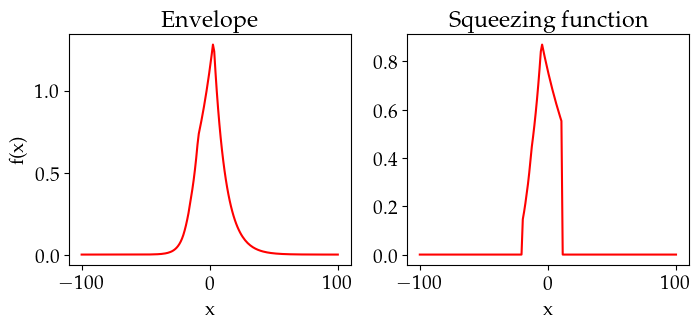

In [276]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(x_plot, gu_abs)
plt.ylabel("f(x)")
plt.xlabel("x")
plt.title("Envelope")

plt.subplot(1,2,2)
plt.plot(x_plot, gl_abs)
plt.xlabel("x")
#plt.ylim(np.min(gu), np.max(gu))
plt.title("Squeezing function")
;

''

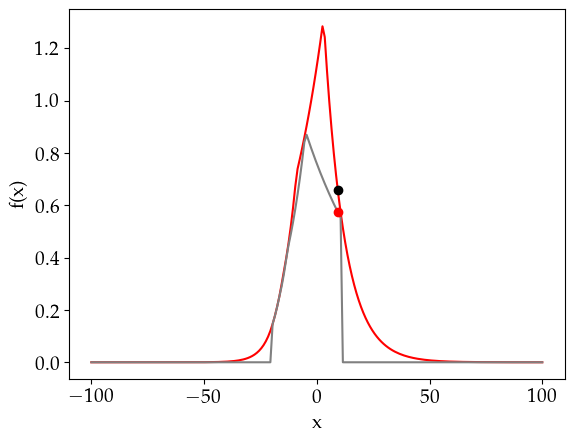

In [281]:
plt.plot(x_plot, gu_abs, label=r"$g_u(x_k)$")
plt.plot(x_plot, gl_abs, label=r"$g_l(x_k)$")
plt.plot(x, gu, "o")
plt.plot(x, gl, "o")
plt.ylabel("f(x)")
plt.xlabel("x")
;

In [284]:
samples = []

while len(samples) < num_samples:
    
    x = sample_envelope(xs, hs, dhdxs, lims)
    
    gl = g_l(x, xs, hs)
    gu = g_u(x, xs, hs, dhdxs)

    # Squeezing test
    u = np.random.rand()

    if u * gu <= gl:
        samples.append(x)
    
    h, dhdx = log_unnorm_prob(x)

    # Rejection test
    if u * gu <= np.exp(h):
        samples.append(x)

    i = np.searchsorted(xs, x)

    xs = np.insert(xs, i, x)
    hs = np.insert(hs, i, h)
    dhdxs = np.insert(dhdxs, i, dhdx)
    


''

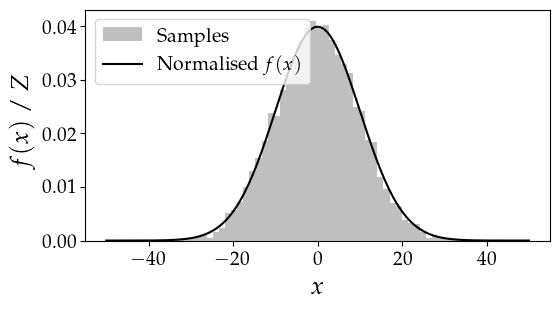

In [311]:
x_plot = np.linspace(-50, 50, 200)
log_probs = [np.exp(log_prob(x)[0]) / (2 * np.pi*target_variance) ** 0.5 for x in x_plot]

# Plot samples and target
plt.figure(figsize=(6, 3))

plt.hist(samples,
        density=True,
        bins=50,
        color='gray',
        alpha=0.5,
        label='Samples')
plt.plot(x_plot,
        log_probs,
        color='black',
        label='Normalised $f(x)$')

# Plot formatting
plt.xlabel('$x$', fontsize=18)
plt.ylabel('$f(x)~/~Z$', fontsize=18)
plt.legend()
;